### Source and Flare Detection for Poisson Noise Data


$P_{poi}(M|B)=\frac{B^{M}e^{-B}}{M!}$

our models for the two hypotheses are:

background only:

$H_{0} : M(q) = poi(B)$

background + signal:

$H_{1}(q_{0},F) : M(q) = poi(B+FPT)$

where F is some constant number (the flux), P is a point spread function in (x,y) and T is some "flare function" of time. the integral of PT over (x,y,t) is 1. and F controls the overall normalisation of the signal strength.

our test statistic, is

$S = \sum_{q}M_{q}log\left(1+\frac{FPT}{B}\right)$

we need to find the S threshold, such that the integral of the PDF of S under the background only hypotehsis, from that threshold to S = $\infty$ is equal to some given $\beta$ (false alarm probability).

now, the PDF of S depends on F (the flux). 
if our data was exactly the signal (FPT) but with the background B subtracted, and we were to multiply it by the filter, the value of S we would get would be:

$S = (F-B)\sum_{q}(PT)_{(q)}log\left(1+\frac{FPT}{B}\right)$

we are sensative only to a flux which would make this value of S at least equal to the threshold S required for false alarm rate $\beta$.

so we must solve numerically the system of two equations:

$\int_{S_{threshold}}^{\infty}PDF_{(S)}dS=\beta$

$S_{threshold} = (F_{threshold}-B)\sum_{q}(PT)_{(q)}log\left(1+\frac{F_{threshold}PT}{B}\right)$

we can start from an intial guess for $F_{threshold}$ as the value of flux that would solve the equation:

$1-\beta = \int_{0}^{F_{threshold}}Pois(f| B\cdot4\pi r^{2} )$

where r is the typical radius of the signal template psf

in order to find the threshold S for a given threshold flux, we need to caclulate the PDF of S, which we can do numerically by generating "background only" monte carlo samples, calculating the value of S in each pixel, and making a histogram of S.

outline:

1. create a template with norm 1.
2. create filter (according to above formula)
3. start with intial guess of threshold flux
4. calculate flux normalisation: $Flux_{norm} = \sum_{q}(PT)_{(q)}log\left(1+\frac{FPT}{B}\right)$
5. generate background only samples
6. collect values of test statistic S (the pixels in the cross correlation of the filter with the images)
7. find the threshold of S such that the false positive rate is some value $\beta$
8. set the next iteration of flux threshold to $F_{threshold} = \frac{S_{threshold}}{Flux_{norm}}+B$
9. go back to 4 and repeat until $F_{threshold}$ has converged
10. repeat for a number of different backgrounds, and for different values of PSF width, and for different decay times.
11. generate images with template inside them, with a varity of flux values
12. use optimal filter to cross correlate with images. for each value of flux, calculate the completeness (the fraction of signals for which the threshold value of S was crossed)
13. repeat also for the "standard" matched filter, where you cross correlate the image only with the template itself.


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal,sparse
from scipy.stats import poisson

In [75]:
def make2Dsliceplot(ar3D,projax,val,title,colorMap=""):
    if projax=='x': ar2D=ar3D[val,:,:]
    if projax=='y': ar2D=ar3D[:,val,:]
    if projax=='z': ar2D=ar3D[:,:,val]
#     fig=plt.figure()
#     ax=fig.add_subplot(111)
    if colorMap=="":
        colorMap = 'viridis'
    plt.imshow(ar2D, cmap=colorMap)
    plt.colorbar(orientation='vertical')
    plt.title("%s for %s=%s"%(title,projax,val))
    plt.show()
    

## Make 3D image filled with noise and substract average
def makeImage(B, nxy,nt, subtractMean = True):
    image=np.random.poisson(B,(nxy,nxy,nt))
    if subtractMean:
        noise_avg=np.mean(image)
        image=image-noise_avg
    return image

## Make template signal and scale to norm_tsig
def makeTemplate(nxy,nt, PSFsigma, decayTime,norm):
    
    timevals = []
    timesteps = []
    
    tsig=np.zeros( (nxy,nxy,nt) )
 
    centerVal = (nxy-1.0)/2.0
    
    for t in range(nt):
        
        timesteps.append(t)
        timevals.append(0)
        
        if t < int(0.5*nt):
            
            continue
        
        if t == int(0.5*nt):
            timesteps.append(t)
            timevals.append(0)
            
        tnorm=np.exp(-t*(1.0/decayTime))
        
        timevals[-1] = tnorm
        
        for i in range(nxy):
            
            for j in range(nxy):
                
                tsig[i][j][t]=(tnorm/np.sqrt(2*np.pi*PSFsigma**2))*np.exp(-((i-centerVal)**2+(j-centerVal)**2)/(2*PSFsigma**2))
    
    tsig*=( norm / float(np.sum(tsig)) )
    
    return [tsig, [timesteps, timevals]]


#
## Add template to image
def addSignalToImg(image, SignalTemplate, signalFlux, positionX, positionY, positionT):    

    nxy = len( SignalTemplate[0] )
    nz = len( SignalTemplate[0][0] )
    
    sigInImg = np.copy( image )
    
    for i in range(nxy):
        for j in range(nxy):
            for t in range(nz):
                sigInImg[i+positionX-nxy/2][j+positionY-nxy/2][t+positionT-nz/2] += np.random.poisson( signalFlux*SignalTemplate[i][j][t] ) 

    return sigInImg


#create the filter from a template, specifiying the flux
def filterTemplate(temp,B,Flux):
    
    nxy = len(temp[0])
    nz = len(temp[0][0])
    
    filt=np.zeros((nxy,nxy,nz))
    
    for i in range(nxy):
        for j in range(nxy):
            for t in range(nz):
                filt[i][j][t]=np.log(1+(Flux*temp[i][j][t])/float(B) )
    
    return filt




#initial flux guess:
def initialFlux(B,templateWidth,beta):
    
    for flux in np.linspace(0,100,1000):
        
        #print flux
        
        equationValue = abs(1.0-beta - poisson.cdf( flux, B*4*np.pi*(templateWidth**2) ))
        #print 'equVal ', equationValue
        
        if  equationValue < 0.01 :
            return flux
    
    print 'failed to find intial flux!'
    return 0

def fluxNormalisation(fluxThreshold, template, filter, Bkg):
    sum = 0
    nXY = len(template[0])
    nT = len(template[0][0])
    

    for i in range(nXY):
        for j in range(nXY):
            for k in range(nT):
                templateValue = template[i][j][k]
                if templateValue==0:
                    continue
                sum += templateValue*np.log(1+(fluxThreshold/float(Bkg))*templateValue )
    return sum


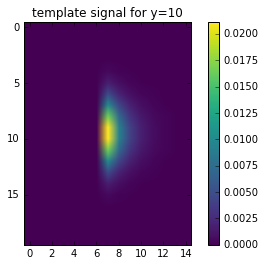

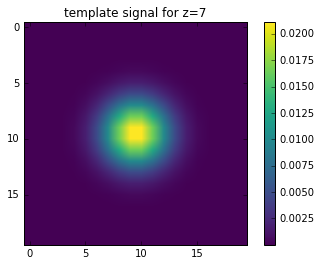

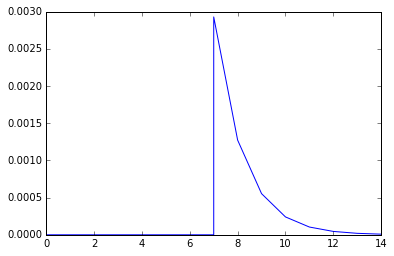

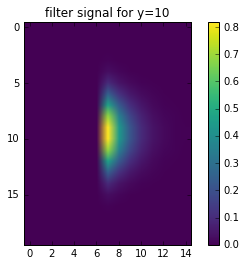

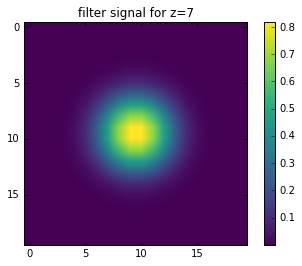

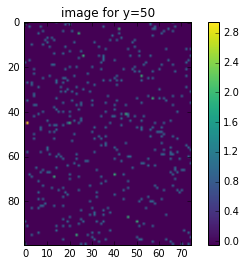

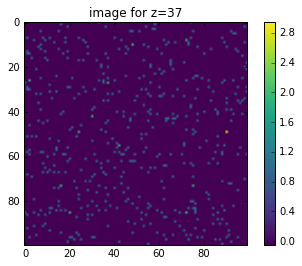

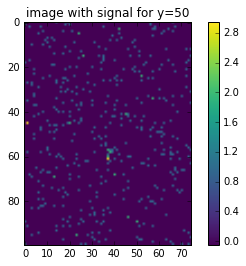

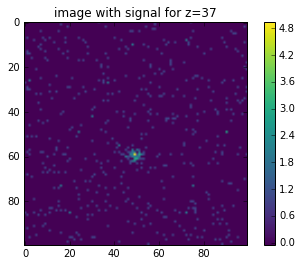

In [78]:
templatesize = 20 #in xy dimension
templateWidth = 2 #std of template gaussian in xy plane
timeLength = 15 #length of time dimension of template
decayTime = 1.2
B = 0.05
Flux = 3

#generate normalized template
template, timefunction = makeTemplate(templatesize,timeLength, templateWidth, decayTime,1)

#draw template
make2Dsliceplot(template,'y',int(templatesize/2),'template signal',"")
make2Dsliceplot(template,'z',int(timeLength/2),'template signal',"")

#draw the "time" function
plt.plot(timefunction[0],timefunction[1])
plt.show()

#create the filter
filter = filterTemplate(template,B,Flux)
#draw the filter
make2Dsliceplot(filter,'y',int(templatesize/2),'filter signal',"")
make2Dsliceplot(filter,'z',int(timeLength/2),'filter signal',"")

#make image without subtracting mean 
img = makeImage(B, templatesize*5,timeLength*5, False)
#draw mean subtracted image
img_mean = np.mean(img)
make2Dsliceplot(img-img_mean,'y',int(templatesize*5/2),'image',"")
make2Dsliceplot(img-img_mean,'z',int(timeLength*5/2),'image',"")

#add template to signal
imgWithSig = addSignalToImg(img, template, 100, int(templatesize*5/2)+10, int(templatesize*5/2), int(timeLength*5/2))
img_mean = np.mean(imgWithSig)
make2Dsliceplot(imgWithSig-img_mean,'y',int(templatesize*5/2),'image with signal',"")
make2Dsliceplot(imgWithSig-img_mean,'z',int(timeLength*5/2),'image with signal',"")

In [79]:
def FindSandFthresholds(arguments, debug):
    
    bkg           = arguments[ 'B'             ]
    beta          = arguments[ 'beta'          ]
    templatesize  = arguments[ 'templatesize'  ]#in xy dimension
    templateWidth = arguments[ 'templateWidth' ]#std of template gaussian in xy plane
    timeLength    = arguments[ 'timeLength'    ]#length of time dimension of template
    decayTime     = arguments[ 'decayTime'     ]
    imageSizeXY   = arguments[ 'imageSizeXY'   ]
    imageSizeT    = arguments[ 'imageSizeT'    ]

    template, timefunction = makeTemplate(templatesize,timeLength, templateWidth, decayTime,1)
    
    initialFth = initialFlux(bkg,templateWidth,beta)
    
    Fth = initialFth
    nIterations = 0
    converged = False
    
    if(debug):
        import datetime
        starttime = datetime.datetime.now()
        print 'starting correlation '+str(starttime)
    
    
    while(not converged):
        nIterations+=1
        
        if(debug):
            print 'iteration: ',nIterations
            print 'Fth ',Fth
        
        filteredT = filterTemplate(template,bkg,Fth)
        
        Sf = fluxNormalisation(Fth, template, filteredT, bkg)
        
        if(debug):
            print 'Flux Normalisation ',Sf
        
        #generate image
        img = makeImage(bkg, imageSizeXY,imageSizeT)
        
        filteredImg = signal.correlate(img,filteredT,'same')
        
        Sthreshold = np.percentile(filteredImg.flatten(),(1-beta)*100.0)
        
        newFth = (Sthreshold/float(Sf))+bkg
        
        if( abs(newFth-Fth) < 0.01*Fth ):
            converged = True
        else:
            Fth = newFth
        
        if nIterations > 10:
            
            print 'reached max iterations'
            break
    
    if(debug):
        endtime = datetime.datetime.now()
        print 'done : '+str(endtime-starttime)
    
        print '\nThreshold S', Sthreshold
        print 'inital Fth ', initialFth
        print 'final Fth ', Fth
    
    return [ Fth, Sthreshold, filteredImg, template, filteredT ]

arguments = {
'B'             : 0.005 ,
'beta'          : 0.001 ,
'templatesize'  : 20    ,
'templateWidth' : 2     ,
'timeLength'    : 15    ,
'decayTime'     : 1.2   ,
'imageSizeXY'   : 50    ,
'imageSizeT'    : 40    ,
}

Fth, Sthreshold, mf, template, filtered = FindSandFthresholds(arguments, True)



starting correlation 2017-09-17 13:04:02.114632
iteration:  1
Fth  2.002002002
Flux Normalisation  1.20869405135
iteration:  2
Fth  4.04469315071
Flux Normalisation  1.68967362415
iteration:  3
Fth  3.36201195583
Flux Normalisation  1.55587207662
iteration:  4
Fth  3.99414954323
Flux Normalisation  1.68041769104
iteration:  5
Fth  4.13190443833
Flux Normalisation  1.70542606596
iteration:  6
Fth  3.48202068555
Flux Normalisation  1.58087668622
iteration:  7
Fth  3.94256060271
Flux Normalisation  1.67087200819
done : 0:01:21.642594

Threshold S 6.53841440453
inital Fth  2.002002002
final Fth  3.94256060271


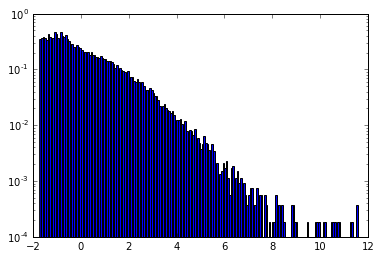

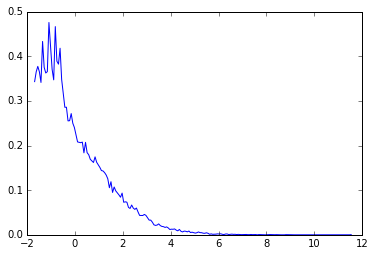

In [60]:
img = makeImage(0.005, 40,50)
mf = signal.correlate(img,filtered,'same')
np.percentile(mf.flatten(),(1-0.001)*100.0)

count, bins, ignored = plt.hist(mf.flatten(),200, normed=True)
plt.yscale('log', nonposy='clip')
plt.show()

bincenters = 0.5*(bins[1:]+bins[:-1])

plt.plot(bincenters,count,'-')
plt.show()

In [86]:
#generate small images with signal inside, in a few values of flux
bkg = 0.005

templatesize = len(template[0])
timeLength = len(template[0][0])

imagelist = []
filteredImages = []

flux = 2*Fth

for i in range(5):
    #make image without subtracting mean
    img = makeImage(bkg, templatesize,timeLength,False)
    #add template to signal with desired flux
    imgWithSig = addSignalToImg(img, template, flux, int(templatesize/2), int(templatesize/2), int(timeLength/2.0))
    #subtract mean from image
    imgWithSig = imgWithSig-np.mean(imgWithSig)
    
    imagelist.append( np.copy(imgWithSig) )
    filteredImages.append( signal.correlate(imgWithSig,filtered,'same') )
    


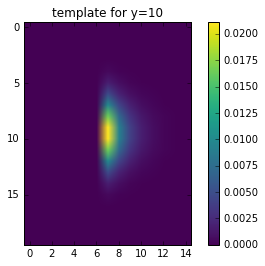

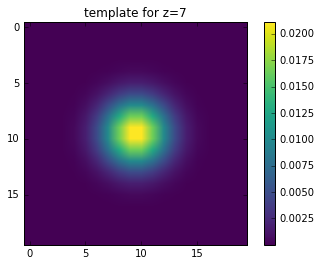

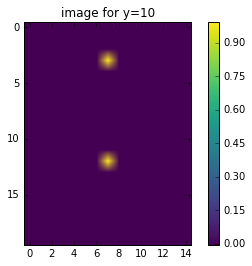

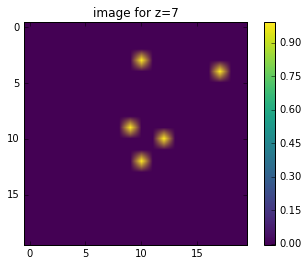

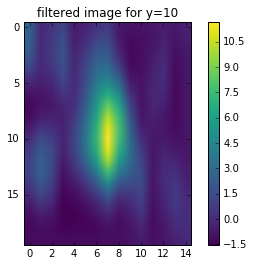

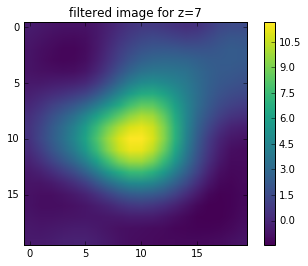

In [87]:
make2Dsliceplot(template,'y',int(templatesize/2),'template',"")
make2Dsliceplot(template,'z',int(timeLength/2),'template',"")

make2Dsliceplot(imagelist[1],'y',int(templatesize/2),'image',"")
make2Dsliceplot(imagelist[1],'z',int(timeLength/2.0),'image',"")

make2Dsliceplot(filteredImages[1],'y',int(templatesize/2),'filtered image',"")
make2Dsliceplot(filteredImages[1],'z',int(timeLength/2.0),'filtered image',"")
